


#The approach followed in this notebook entails computing a number of behavioral indicators,
    defining the target variable,
    performing exploratory data analysis
    preprocessing of data
Classification with cross validation is followed by a section on the the receiver operation characteristic (ROC) curve.
optimal classifier parameters.


## Computing the indicators
bandicoot allows us analyze and extract behavioral indicators from mobile phone data. With bandicoot, it is easy to load all the users in Friends and Family dataset and automatically compute their indicators.

The dataset provided contains 129 users interacting with each other. Each CSV file contains call and text metadata records belonging to a single user.

#### Load libraries and set options

In [1]:
# Load libraries and set options.
import matplotlib.pyplot as plt
import bandicoot as bc
from tqdm import tqdm_notebook as tqdm  # Interactive progress bar.
import glob
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9) 
plt.rcParams['axes.titlesize'] = 'large'

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## Supervised learning.
from sklearn import svm, linear_model, ensemble, neighbors, tree
from sklearn import metrics, cross_validation, preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import Perceptron
from mlxtend.classifier import MultiLayerPerceptron as MLP

####  Create a function to load a user and returns all the indicators

In [2]:
def make_features(user_id):
    '''
    Compute and return indicators of a specific user
    '''
    user = bc.read_csv(user_id, "bandicoot-training-master/data-fnf/records/",
                       attributes_path="../data/bandicoot/attributes/subsector/",
                       describe=False, warnings=False)

    return bc.utils.all(user, summary='extended', split_day=True, split_week=True)

####  Create a list of users with their features from all the CSV files 

In [3]:
# Read all the csv files in the in "./data-fnf/records" directory.
all_features = []

# Process all the files in the specified directory using the function created previously.
for f in glob.glob("./bandicoot-training-master/data-fnf/records/*.csv"):
    user_id = os.path.basename(f)[:-4]  # Remove .csv extension.
    all_features.append(make_features(user_id))
    
# Export all features in one file (fnf_features.csv).
bc.io.to_csv(all_features, 'fnf_features.csv')

Successfully exported 129 object(s) to fnf_features.csv


####  Load the features and attributes to a dataframe

In [4]:
# Load the features and attributes to a dataframe using the pandas library.
df = pd.read_csv('fnf_features.csv')
df.head()

,name,reporting__antennas_path,reporting__attributes_path,reporting__recharges_path,reporting__version,reporting__code_signature,reporting__groupby,reporting__split_week,reporting__split_day,reporting__start_time,...,frequent_antennas__weekend__allday__std,frequent_antennas__weekend__day__mean,frequent_antennas__weekend__day__std,frequent_antennas__weekend__night__mean,frequent_antennas__weekend__night__std,churn_rate__mean,churn_rate__std,attributes__gender,attributes__sub,attributes__individual_id
0,sp10-01-45,NaN,../data/bandicoot/attributes/subsector/,../data/bandicoot/attributes/subsector/,0.5.3,9448acf6f41035dc77ec1442688b811e522ffb4d,week,True,True,2010-07-26 23:33:53,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,female,0.0,sp10-01-45
1,fa10-01-53,NaN,../data/bandicoot/attributes/subsector/,../data/bandicoot/attributes/subsector/,0.5.3,9448acf6f41035dc77ec1442688b811e522ffb4d,week,True,True,2010-10-21 19:14:12,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,male,1.0,fa10-01-53
2,fa10-01-08,NaN,../data/bandicoot/attributes/subsector/,../data/bandicoot/attributes/subsector/,0.5.3,9448acf6f41035dc77ec1442688b811e522ffb4d,week,True,True,2010-08-20 17:34:22,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,female,1.0,fa10-01-08
3,fa10-01-07,NaN,../data/bandicoot/attributes/subsector/,../data/bandicoot/attributes/subsector/,0.5.3,9448acf6f41035dc77ec1442688b811e522ffb4d,week,True,True,2010-09-08 11:10:59,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,male,1.0,fa10-01-07
4,fa10-01-31,NaN,../data/bandicoot/attributes/subsector/,../data/bandicoot/attributes/subsector/,0.5.3,9448acf6f41035dc77ec1442688b811e522ffb4d,week,True,True,2010-10-17 15:10:49,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,male,1.0,fa10-01-31


##  Exploratory Data Analysis

Exploratory data analysis (EDA) is a critical first step in any data analysis project and is useful for the following reasons.

- Detecting errors in data
- Validating our assumptions
- Guide in the selection of appropriate models
- Determining relationships among the explanatory variables
- Assessing the direction and size (roughly) of relationships between predictor/explanatory and response/target variables

 

In [5]:
# First extract the groups by target variable.
sub_gr=df.groupby('attributes__sub')

##### Are there any differences in the distribution of 'call durations' between the two groups?

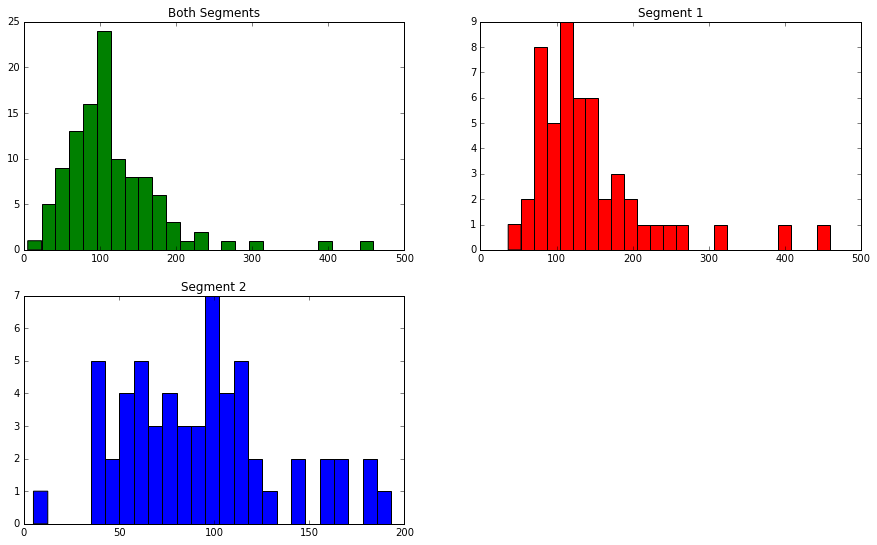

In [6]:
# Plot both segments.
plt.subplot(2,2,1)
_ = plt.hist(df['call_duration__allweek__allday__call__mean__mean'].dropna(), bins=25, color='green')
plt.title('Both Segments')

# Plot Segment 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0) ['call_duration__allweek__allday__call__mean__mean'].dropna().values, bins=25, color='red') 
plt.title('Segment 1')

# Plot Segment 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['call_duration__allweek__allday__call__mean__mean'].dropna().values,bins=25)
plt.title('Segment 2')

##### Are there any differences in the distribution of number of interactions between the two groups?

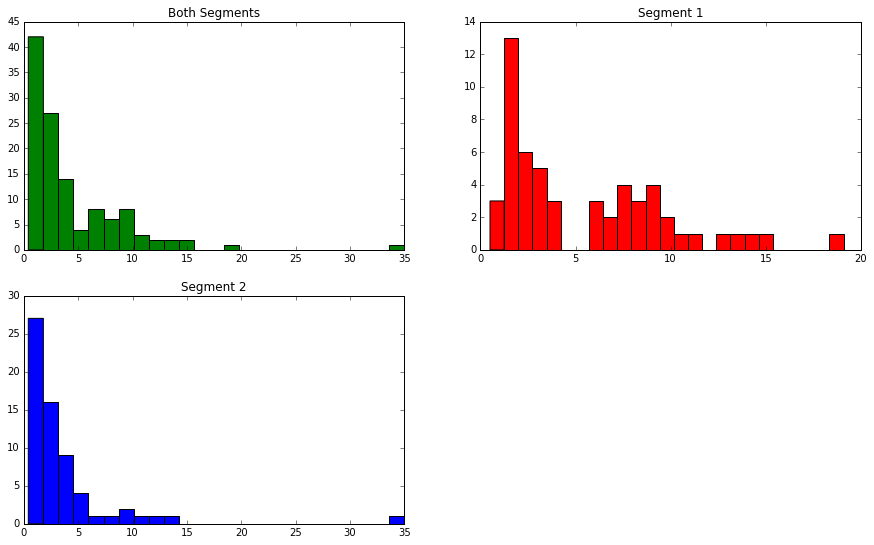

In [7]:
# Plot both segments.
plt.subplot(2,2,1)
#df['call_duration__allweek__allday__call__mean__mean'].hist(bins=100)
_ = plt.hist(df['number_of_interaction_in__allweek__night__text__mean'].dropna(), bins=25, color='green')
plt.title('Both Segments')

# Plot segment 1.
plt.subplot(2,2,2)
_ = plt.hist(sub_gr.get_group(0)['number_of_interaction_in__allweek__night__text__mean'].dropna().values, bins=25, color='red')
plt.title('Segment 1')

# Plot segment 2.
plt.subplot(2,2,3)
_ = plt.hist(sub_gr.get_group(1)['number_of_interaction_in__allweek__night__text__mean'].dropna().values,bins=25)
plt.title('Segment 2')

## Data preprocessing

We need to preprocess the data to make it usable for machine learning purposes. This involves a number of activities such as 
1. Assigning numerical values to factors
1. Handling missing values
2. Normalize the features (so features on small scales do not dominate when fitting a model to the data)

Sklearn fuctions:
- `preprocessing`
- `preprocessing.Imputer()`

> **Note**: Small scale imply big value. As example, assume we are classifying people based on their physiological characteristics. A small scale feature would be weight measured in kilograms vs height measured in meters. 

Sklearn functions:
- `preprocessing.StandardScaler()`

First, make sure that we only have records in the dataset that are labeled. Our target variable is a socio-economic binary indicator   ```df.attributes__sub```

In [8]:
# Drop records with missing labels in the target variable.
df = df[~df.attributes__sub.isnull()]

 created two objects to use in building the classifier:

- the array ``y`` contains the labels we want to predict (cluster 1 / cluster 2),
- the matrix ``X`` contains the features for all users (one column for one feature, one line for one user).

In [9]:
# 1. Target variable.
y = df.attributes__sub.astype(np.int)
y.values

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [10]:
# Convert gender labels to binary values (zero or one):
df.loc[:,'attributes__gender'] = (df.attributes__gender == 'female').values.astype(np.int)

/home/ubuntu/.local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
# 2. Remove columns with reporting variables and attributes. (the first 39 and the last 2):
df = pd.concat([df[df.columns[39:-5]],df[df.columns[-3]]], axis=1)
X = df.values
X

array([[ 5.59091,  1.38692,  5.22727, ...,  1.     ,  0.     ,  1.     ],
       [ 4.09091,  2.55679,  4.09524, ...,  1.     ,  0.     ,  0.     ],
       [ 4.52632,  1.90203,  4.05263, ...,  1.     ,  0.     ,  1.     ],
       ..., 
       [ 5.75556,  1.35246,  5.2    , ...,  1.     ,  0.     ,  1.     ],
       [ 6.06818,  1.32112,  5.68182, ...,  1.     ,  0.     ,  1.     ],
       [ 3.1    ,  1.51327,  2.71429, ...,  1.     ,  0.     ,  0.     ]])

In [12]:
# 3. Impute the missing values in the features.
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

#### Normalization
Normalize the data to center it around zero and transform it to a similiar scale to prevent variables in 'small' units (and therefore high values) to dominate the classification unreasonably.

In [13]:
# 4. Preprocess data (center around 0 and scale to remove the variance).
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)

##  Classification with cross-validation

> Support vector machines (SVMs) one of the popular linear classifiers that are based on two central ideas of margin maximization and kernel functions. Margin maximization allows one to find an optimal hyperplane that separates linearly data, while kernel functions extend the algorithm to handle data not linearly separable by mappping the data into a new high-dimensional space. A rough intuitive explanation of how it works can be found here: http://www.dataschool.io/comparing-supervised-learning-algorithms/

In [14]:
# 5. Divide records in training and testing sets.
np.random.seed(2)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xs, y, test_size=0.3, stratify=y.values)

# 6. Create an SVM classifier and train it on 70% of the data set.
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

# 7. Analyze accuracy of predictions on 30% of the holdout test sample.
classifier_score = clf.score(X_test, y_test)
print '\nThe classifier accuracy score is {:.2f}\n'.format(classifier_score)


The classifier accuracy score is 0.62



To get a better measure of prediction accuracy (which we can use as a proxy for goodness of fit of the model), we can successively split the data in folds that we use for training and testing:

In [15]:
# Get average of 3-fold cross-validation score using an SVC estimator.
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print '\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error)


The 3-fold cross-validation accuracy score for this classifier is 0.68



##  Receiver operating characteristic (ROC) curve. 

In statistical modeling and machine learning,  a commonly reported performance measure of model accuracy is Area Under the Curve (AUC), where by *curve* the ROC curve is implied. ROC stands for *Receiver Operating Characteristic* - a term originated from the second world war and used by by radar engineers.

To understand what information the ROC curve conveys, consider the the so-called confusion matrix that basically is a 2-dimensional table where the classifier model is on one axis (vertical) and ground truth is on the other (horizontal) axis as shown below. Either of these axis can take two values as depicted. A cell in the table then is an intersection where the conditions on each the dimensions hold. For example, in the top left cell, the model condition is "A" and the ground truth is also "A". Hence, the count of instances where these 2 conditions are true (for a specific data point) is captured, hence the label 'True positive'. The same logic applies to the rest of the other cells. The total of the counts in these cells therefore must equal the number of data instances in our data set under consideration.


~~~~
                        Actual: A        Not A

  Model says “A”       True positive   |   False positive
                      ----------------------------------
  Model says “Not A”   False negative  |    True negative
  
~~~~



In an ROC curve, we plot ‘True Positive Rate‘ on Y-axis and ‘False Positive Rate‘ on the X-axis, where the the “true positive”, “false negative”, “false positive” and “true negative” are events (or their probability) as described above, and where the rates are defined according to:

> True positive rate (or sensitivity)}:  **tpr = tp / (tp + fn)**

> False positive rate:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                   **fpr = fp / (fp + tn)**

> True negative rate (or specificity):   **tnr = tn / (fp + tn)**

In all definitions the column total is the denominator. We can therefore express the true positive rate (tpr) as the probability that the model says “A” when the real value is indeed A (i.e., a conditional probability). This does not tell you how likely you are to be correct when calling “A” (i.e., the probability of a true positive, conditioned on the test result being “A”).

To interpret the ROC correctly, consider the points that lie on along the diagonal represent. For these situation, there is an equal chance of "A" and "not A" happening. Therefore,  this is not that different from making a prediction by tossing of an unbiased coin, or put simply, the classification model is random.

For points above the diagonal, **tpr** > **fpr**, and our model says we are in a zone where we are performing better than random. For example, assume **tpr ** = 0.6 and **fpr** = 0.2, then the probability of our being in the true positive group is $(0.6 / (0.6 + 0.2)) = 75\%$. Furthermore, holding **fpr** constant, it is easy to see that the more vertically above the diagonal we are positioned, the better the classification model. Further basic details on the correct interpretation can be found in this [reference](\http://pubs.rsna.org/doi/pdf/10.1148/radiographics.12.6.1439017).

In [16]:
# The confusion matrix helps visualize the performance of the algorithm.
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test.values, y_pred)

print(cm)

[[ 9  9]
 [ 6 15]]


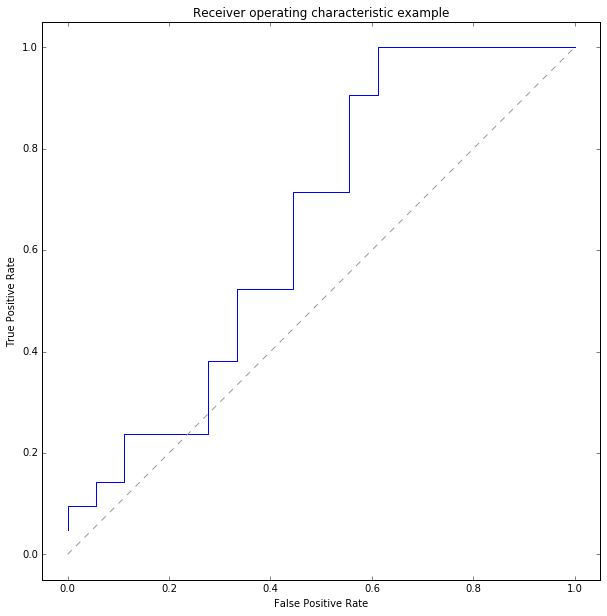

In [17]:
# Plot the receiver operating characteristic curve (ROC).
plt.figure(figsize=(20,10))
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.axes().set_aspect(1)

Your answer here
ROC curve is a graphical plot that created by plotting the true positive rate(tpr)  against the false positive rate(fpr) at various threshold settings. It illustrates the performance of a binary classifier system. The diagonal line in the graph divide the space into two where the points above the diagonal tpr > fpr and we say our model is performing better than random. The points on diagonal have equal probability to be happening (0, 50%) or not happening (1, 50%). At diagonal the point represents similar to the case of random flipping the coin where head and tail have equal probability of 50% or .5

#  Optimal classifier parameters

The examples above made use of the SVC() function using default parameters. Usually, you would want to optimize the setting of these parameters for a given problem, as these are learned by the algorithm during the training phase. In the case of support vector classifiers, these parameters include kernel choice,
the kernel parameters (Gaussian kernel: $\gamma$; Polynomial kernel: $d$), as well as the penalty for misclassification ($C$). For an illustration of the behavior of these and other kernels explore the [scikit docs](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html)resource. 

Tuning parameters for an optimal solution is inherently difficult. A popular approach is to perform a search over the a grid defined across the various parameters to be optimized for. The grid search function is illustrated next. This illustration will consider optimizing over two parameters - $C$ (misclassification cost) $\gamma$ (The RBF kernel parameter).

In [18]:
# Train classifiers.
param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6)}
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 0.001} with a score of 0.67


In [20]:
grid.best_estimator_.probability = True
clf = grid.best_estimator_

In [21]:
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

print(cm)

[[ 9  9]
 [ 6 15]]


## Using other classifiers

The SVM classifier used is just one option of classifiers that you have at your disposal. There are other classification methods implemented in scikit-learn (as well as mlxtend) that you can easily use. These include:

- Decision trees with ``tree.DecisionTreeClassifier()``;
- K-nearest neighbors with ``neighbors.KNeighborsClassifier()``;
- Random forests with ``ensemble.RandomForestClassifier()``;
- Perceptron (both gradient and stochastic gradient) ``mlxtend.classifier.Perceptron``; and 
- Multilayer perceptron network (both gradient and stochastic gradient) ``mlxtend.classifier.MultiLayerPerceptron``.

It is important to understand the underlying technique, as well as the implementation, in order to correctly interpret the output, or tune the estimator parameters. Next, the use of some of these classifiers is illustrated on the data set using the above-mentioned libraries.

In [22]:
# Create an instance of random forest classifier, fit the data, and assess performance on test data.
clf_rf = ensemble.RandomForestClassifier(n_estimators=200,n_jobs=-1,max_depth=5 )    
n_folds = 3
cv_error = np.average(cross_val_score(clf_rf, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_rf.fit(X_train, y_train)
print '\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error)                             


The 3-fold cross-validation accuracy score for this classifier is 0.69



In [23]:
# Create an instance of logistic regression classifier, fit the data, and assess performance on test data.
clf_logreg = linear_model.LogisticRegression(C=1e5)    
n_folds = 3
cv_error = np.average(cross_val_score(clf_logreg, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_logreg.fit(X_train, y_train)
print '\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error) 


The 3-fold cross-validation accuracy score for this classifier is 0.66



In [24]:
# Create an instance of decision tree classifier, fit the data, and assess performance on test data.
clf_tree = tree.DecisionTreeClassifier()
n_folds = 3
cv_error = np.average(cross_val_score(clf_tree, 
                                      X_train, 
                                      y_train, 
                                      cv=n_folds))
clf_tree = clf_tree.fit(X_train, y_train)
print '\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error)



The 3-fold cross-validation accuracy score for this classifier is 0.68



In [25]:
# Create an instance of multilayer perceptron classifier (gradient descent), fit the data, and assess performance on test data.
clf_nn1 = MLP(hidden_layers=[40],l2=0.00,l1=0.0,epochs=150,eta=0.05,momentum=0.1,decrease_const=0.0,minibatches=1,random_seed=1,print_progress=3)
clf_nn1 = clf_nn1.fit(X_train, y_train)
clf_nn1.score(X_test, y_test)

Iteration: 150/150 | Cost 0.05 | Elapsed: 0:00:03 | ETA: 0:00:00

0.53846153846153844

In [26]:
# Create an instance of multilayer perceptron classifier (stochastic gradient descent), fit the data, and assess performance on test data.
clf_nn2 = MLP(hidden_layers=[40],l2=0.00,l1=0.0,epochs=50,eta=0.05,momentum=0.1,decrease_const=0.0,minibatches=len(y_train),random_seed=1,print_progress=3)
clf_nn2 = clf_nn2.fit(X_train, y_train)
clf_nn2.score(X_test, y_test)

Iteration: 50/50 | Cost 0.00 | Elapsed: 0:00:12 | ETA: 0:00:00

0.66666666666666663

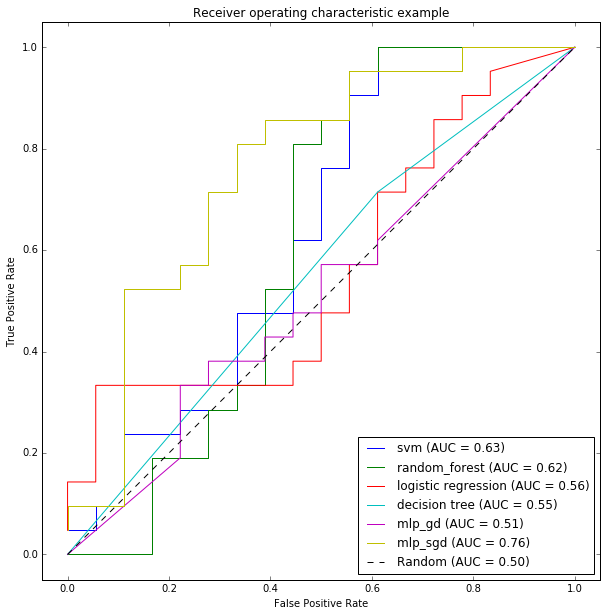

In [27]:
# Plot the results.
colors = ['b', 'g', 'r','c','m','k','y']
classifiers = ['svm','random_forest', 'logistic regression', 'decision tree', 'mlp_gd', 'mlp_sgd']
plt.figure(figsize=(20,10))
for i, cl in enumerate([clf, clf_rf, clf_logreg, clf_tree,clf_nn1, clf_nn2]):
    probas_ = cl.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=classifiers[i]+' (AUC = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=colors[i], label='Random (AUC = 0.50)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.axes().set_aspect(1)
plt.legend(loc="lower right")